In [31]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [32]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
#upload calls and resons dataset
calls_df = pd.read_csv('/content/calls.csv')
reasons_df = pd.read_csv('/content/reasons.csv')

merged_df = pd.merge(calls_df, reasons_df, on='call_id')

In [34]:
def preprocess_text(text):
    filler_words = ['uhh', 'umm', 'yeah', 'okay', 'alright', 'like', 'you know']
    text = ' '.join(word for word in text.split() if word.lower() not in filler_words)

    agent_phrases = [
        r'thank you for calling united airlines customer service.*?',
        r'thank you for your patience.*?',
        r'(my name is .*? how may i help you\?)',
        r'(thank you for flying with us.*)'
    ]
    for phrase in agent_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)

    contractions = {"don't": "do not", "can't": "cannot", "i'm": "i am", "it's": "it is", "isn't": "is not"}
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text, flags=re.IGNORECASE)

    text = re.sub(r'[^a-zA-Z\s\?\!]', '', text)

    text = text.lower()

    domain_specific_stopwords = ['flight', 'airline', 'reservation', 'book', 'united']  # Add domain-specific stopwords
    all_stopwords = stop_words.union(domain_specific_stopwords)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in all_stopwords)

    return text



merged_df['cleaned_transcript'] = merged_df['call_transcript'].apply(preprocess_text)


In [35]:
merged_df['primary_call_reason'] = (
    merged_df['primary_call_reason']
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', ' ', regex=True)
)

cleaned_call_frequency = merged_df['primary_call_reason'].value_counts()

print(cleaned_call_frequency)

primary_call_reason
irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post-flight               3957
communications            3840
products and services     2856
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
check-in                  1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
products & services        476
disability                 403
check in                   385
post flight                373
unaccompanied minor        104
Name: count, dtype: int64


In [36]:
X = self_solvable_df['cleaned_transcript']
y = self_solvable_df['primary_call_reason'].str.lower()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', RandomForestClassifier(random_state=42))
])

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__class_weight': [class_weights, None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

In [38]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[  0   0   0 206   0 337   0   0]
 [  0   0   0 115   0 204   0   0]
 [  0   0   0  86   0 142   0   0]
 [  0   0   0 494   0 675   0   0]
 [  0   0   0  48   0 100   0   0]
 [  0   0   0 428   0 817   0   0]
 [  0   0   0  64   0 121   0   0]
 [  0   0   0 114   0 224   0   0]]

Classification Report:
                   precision    recall  f1-score   support

         booking       0.00      0.00      0.00       543
        check-in       0.00      0.00      0.00       319
 digital support       0.00      0.00      0.00       228
    mileage plus       0.32      0.42      0.36      1169
 schedule change       0.00      0.00      0.00       148
         seating       0.31      0.66      0.42      1245
traveler updates       0.00      0.00      0.00       185
voluntary cancel       0.00      0.00      0.00       338

        accuracy                           0.31      4175
       macro avg       0.08      0.13      0.10      4175
    weighted avg       0.18      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



F1 Score: 0.23


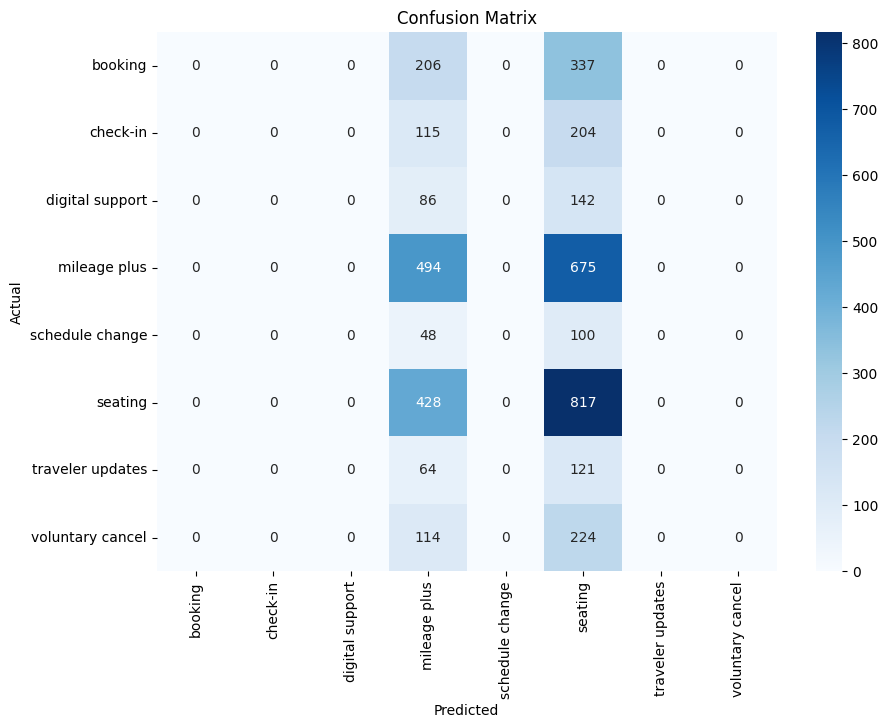


Misclassifications:
                  Actual     Predicted
47100           booking  mileage plus
16288   schedule change       seating
2764       mileage plus       seating
24275   digital support       seating
59748      mileage plus       seating
...                 ...           ...
17002           seating  mileage plus
29467  voluntary cancel       seating
40600      mileage plus       seating
19519           seating  mileage plus
17925          check-in       seating

[2864 rows x 2 columns]


In [39]:

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nF1 Score: {f1:.2f}")

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

misclassifications = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print("\nMisclassifications:\n", misclassifications[misclassifications['Actual'] != misclassifications['Predicted']])
